# MLP
Like MLP_207 with K=5 and epochs=200.

Use GMM for threshold.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-29 22:21:21.222905


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=200 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = set([0,2,3,4,5,6,7,8,9,10,11,12,13,14,15])   # only H1.hESC
FILTER_TAILS_TRAIN  = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TRAIN = False
FILTER_MIDDLE_TEST  = False
FILTER_NONE         = True

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(64, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    layer3 = Dense(64, activation='sigmoid')
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(layer3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam",metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-29 22:21:47.723515
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                65664     
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74,049
Trainable params: 74,049
Non-trainable params: 0
_________________________________________________________________
None


## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_NONE or \
                    (FILTER_TAILS_TEST and in_middle) or \
                    (FILTER_MIDDLE_TEST and in_tails):
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_NONE or \
                    (FILTER_TAILS_TRAIN and in_middle) or \
                    (FILTER_MIDDLE_TRAIN and in_tails):
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-29 22:21:48.052287
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 3774
Num RCI: 3774
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 3774 sequences.
2023-03-29 22:21:59.850725

Training # 1 1
2023-03-29 22:21:59.853440
2023-03-29 22:21:59.853798
Discriminator ZERO -1
Train 1:0 1911:1120 63.05%
Computed class weights: {0: 1.353125, 1: 0.793040293040293}
Valid 1:0 488:255 65.68%
FIT
2023-03-29 22:21:59.918667


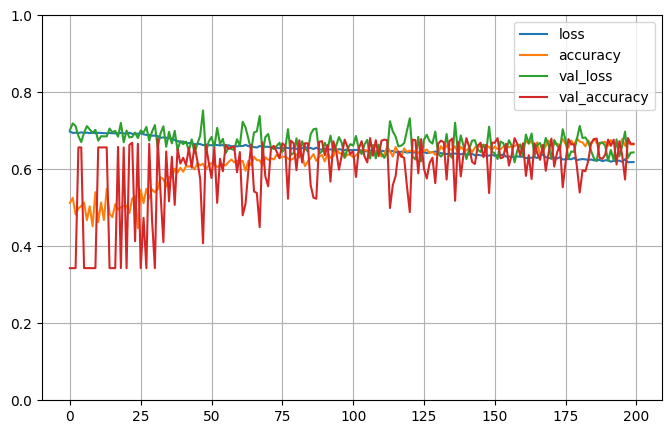


2023-03-29 22:23:23.248030

Testing # 1 1
2023-03-29 22:23:23.248124
2023-03-29 22:23:23.248752
PREDICT
2023-03-29 22:23:23.252611
Test 1:0 488:255 65.68%
Predict 1:0 508:235 68.37%
Test sizes (743, 1025) (743,)
Range of scores: 0.038288556 to 0.9775512
Score threshold 0.5
Confusion matrix
 [[121 134]
 [114 374]]
Normalized matrix
 [[0.1628533  0.18034993]
 [0.15343203 0.50336474]]


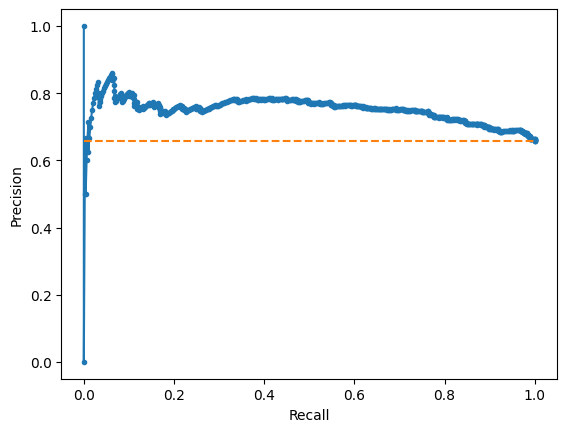

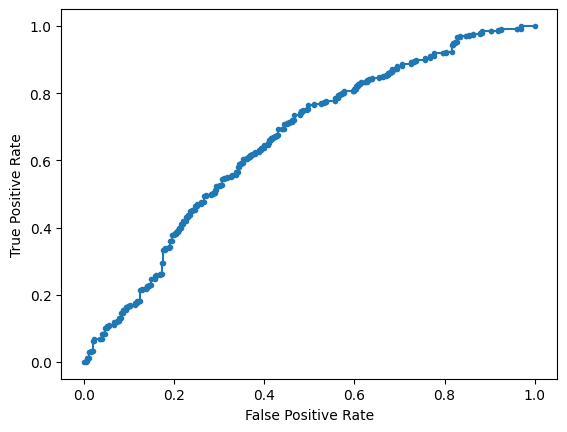

Accuracy: 66.62% Precision: 73.62% Recall: 76.64%
F1: 75.10% MCC: 0.2460
AUPRC: 75.04% AUROC: 65.76%
 accuracy [66.62180349932704]
 precision [73.62204724409449]
 recall [76.63934426229508]
 F1 [75.10040160642572]
 MCC [0.24595568585523703]
 AUPRC [75.03672231935128]
 AUROC [65.7569913211186]
2023-03-29 22:23:24.057231

Training # 1 2
2023-03-29 22:23:24.058851
2023-03-29 22:23:24.059254
Discriminator ZERO -1
Train 1:0 1914:1098 63.55%
Computed class weights: {0: 1.3715846994535519, 1: 0.786833855799373}
Valid 1:0 485:277 63.65%
FIT
2023-03-29 22:23:24.107151


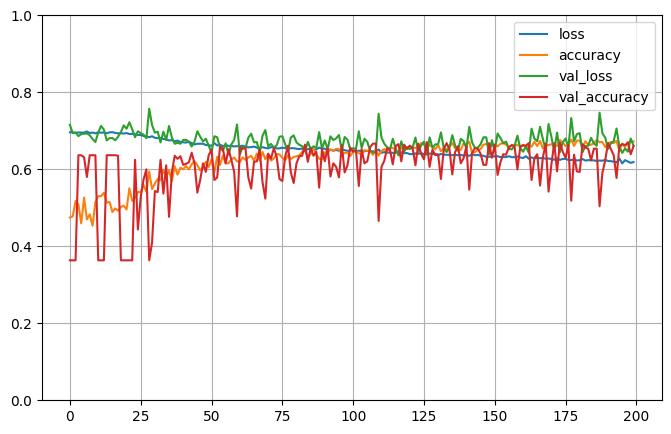


2023-03-29 22:24:18.601032

Testing # 1 2
2023-03-29 22:24:18.602488
2023-03-29 22:24:18.602803
PREDICT
2023-03-29 22:24:18.608491
Test 1:0 485:277 63.65%
Predict 1:0 518:244 67.98%
Test sizes (762, 1025) (762,)
Range of scores: 0.018707642 to 0.98520577
Score threshold 0.5
Confusion matrix
 [[131 146]
 [113 372]]
Normalized matrix
 [[0.17191601 0.19160105]
 [0.14829396 0.48818898]]


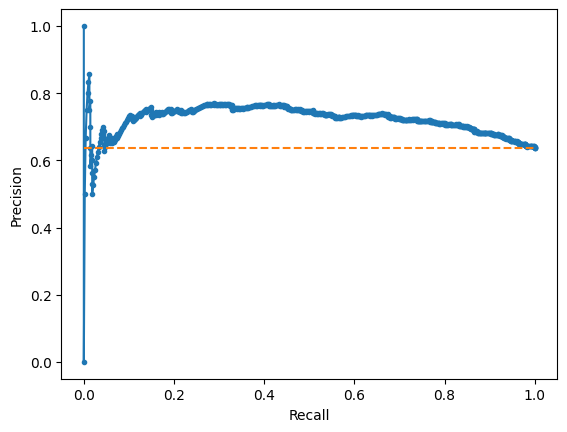

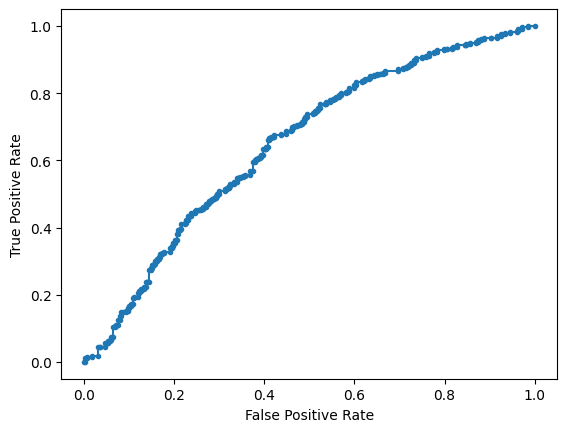

Accuracy: 66.01% Precision: 71.81% Recall: 76.70%
F1: 74.18% MCC: 0.2474
AUPRC: 72.13% AUROC: 64.82%
 accuracy [66.01049868766404]
 precision [71.81467181467181]
 recall [76.70103092783506]
 F1 [74.17746759720838]
 MCC [0.24736807800094246]
 AUPRC [72.12784704180902]
 AUROC [64.82340243403178]
2023-03-29 22:24:19.388614

Training # 1 3
2023-03-29 22:24:19.390653
2023-03-29 22:24:19.391043
Discriminator ZERO -1
Train 1:0 1925:1106 63.51%
Computed class weights: {0: 1.370253164556962, 1: 0.7872727272727272}
Valid 1:0 474:269 63.80%
FIT
2023-03-29 22:24:19.448933


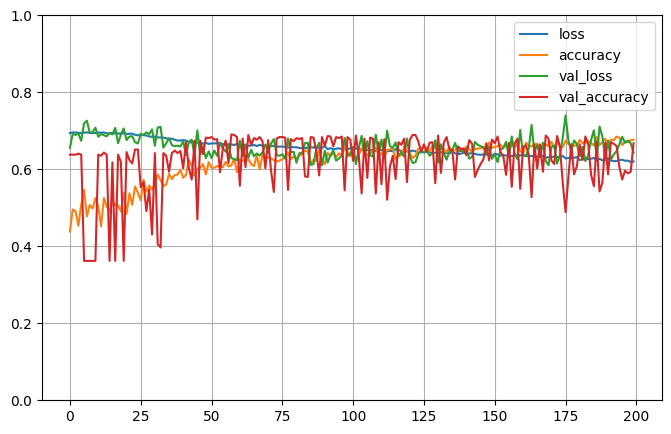


2023-03-29 22:25:17.299176

Testing # 1 3
2023-03-29 22:25:17.299240
2023-03-29 22:25:17.299274
PREDICT
2023-03-29 22:25:17.305074
Test 1:0 474:269 63.80%
Predict 1:0 455:288 61.24%
Test sizes (743, 1025) (743,)
Range of scores: 0.018832142 to 0.9696383
Score threshold 0.5
Confusion matrix
 [[155 114]
 [133 341]]
Normalized matrix
 [[0.20861373 0.15343203]
 [0.17900404 0.4589502 ]]


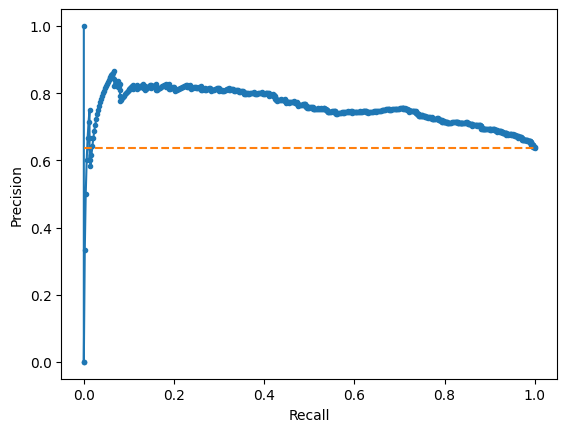

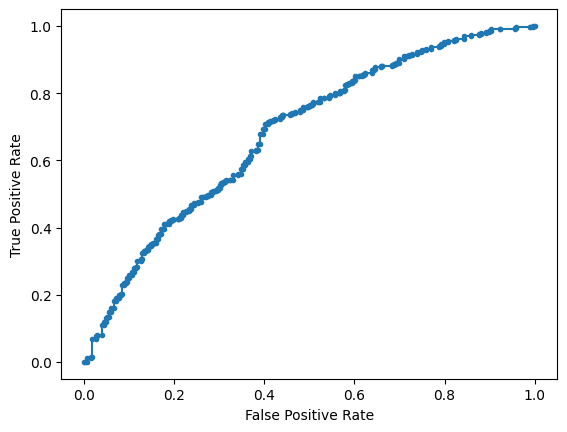

Accuracy: 66.76% Precision: 74.95% Recall: 71.94%
F1: 73.41% MCC: 0.2916
AUPRC: 75.78% AUROC: 68.12%
 accuracy [66.7563930013459]
 precision [74.94505494505495]
 recall [71.94092827004219]
 F1 [73.41227125941873]
 MCC [0.29160398283392036]
 AUPRC [75.77625091462845]
 AUROC [68.12228444151647]
2023-03-29 22:25:18.039888

Training # 1 4
2023-03-29 22:25:18.041218
2023-03-29 22:25:18.041414
Discriminator ZERO -1
Train 1:0 1939:1087 64.08%
Computed class weights: {0: 1.391904323827047, 1: 0.7802991232594121}
Valid 1:0 460:288 61.50%
FIT
2023-03-29 22:25:18.097991


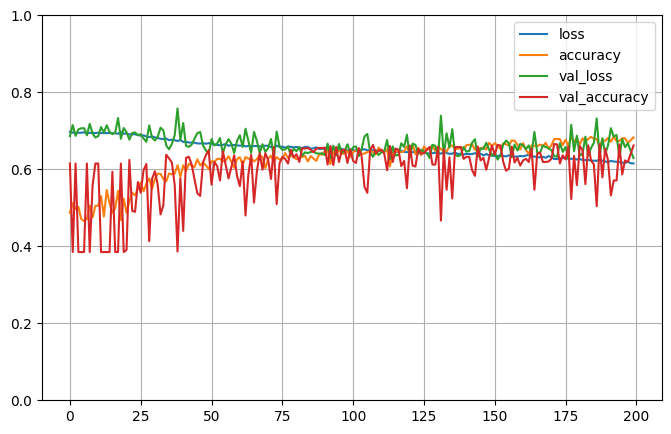


2023-03-29 22:26:41.008879

Testing # 1 4
2023-03-29 22:26:41.010552
2023-03-29 22:26:41.010883
PREDICT
2023-03-29 22:26:41.015545
Test 1:0 460:288 61.50%
Predict 1:0 615:133 82.22%
Test sizes (748, 1025) (748,)
Range of scores: 0.02347487 to 0.97125393
Score threshold 0.5
Confusion matrix
 [[ 84 204]
 [ 49 411]]
Normalized matrix
 [[0.11229947 0.27272727]
 [0.06550802 0.54946524]]


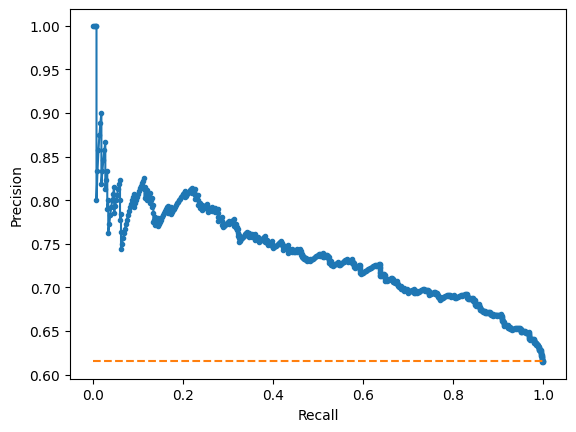

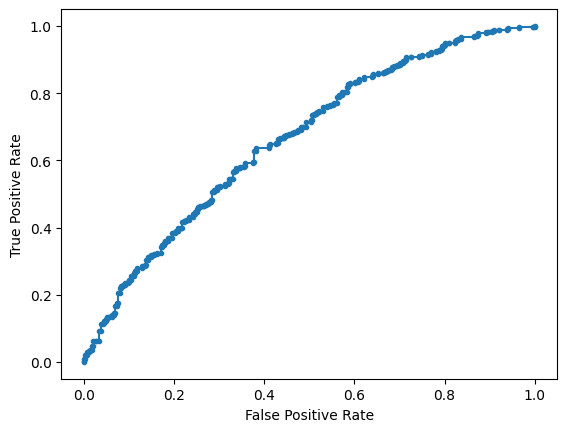

Accuracy: 66.18% Precision: 66.83% Recall: 89.35%
F1: 76.47% MCC: 0.2356
AUPRC: 73.73% AUROC: 66.36%
 accuracy [66.17647058823529]
 precision [66.82926829268293]
 recall [89.34782608695652]
 F1 [76.46511627906978]
 MCC [0.23562621089595664]
 AUPRC [73.7268924062382]
 AUROC [66.36322463768116]
2023-03-29 22:26:41.669824

Training # 1 5
2023-03-29 22:26:41.671853
2023-03-29 22:26:41.671954
Discriminator ZERO -1
Train 1:0 1907:1089 63.65%
Computed class weights: {0: 1.3755739210284665, 1: 0.7855270057682223}
Valid 1:0 492:286 63.24%
FIT
2023-03-29 22:26:41.729025


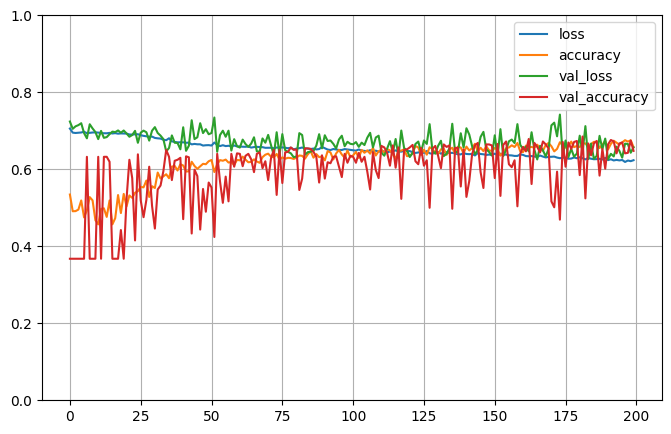


2023-03-29 22:27:38.742758

Testing # 1 5
2023-03-29 22:27:38.743932
2023-03-29 22:27:38.744233
PREDICT
2023-03-29 22:27:38.751369
Test 1:0 492:286 63.24%
Predict 1:0 446:332 57.33%
Test sizes (778, 1025) (778,)
Range of scores: 0.04559304 to 0.9084238
Score threshold 0.5
Confusion matrix
 [[172 114]
 [160 332]]
Normalized matrix
 [[0.22107969 0.14652956]
 [0.20565553 0.42673522]]


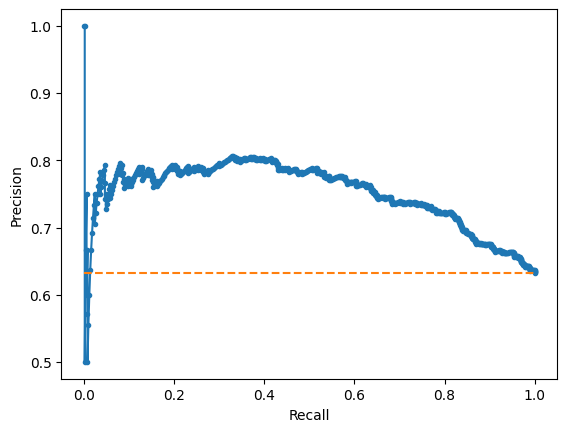

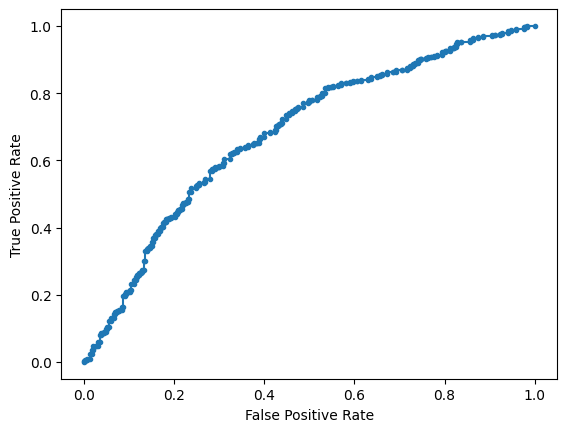

Accuracy: 64.78% Precision: 74.44% Recall: 67.48%
F1: 70.79% MCC: 0.2692
AUPRC: 75.09% AUROC: 68.08%
 accuracy [64.78149100257069]
 precision [74.43946188340807]
 recall [67.47967479674797]
 F1 [70.78891257995737]
 MCC [0.26924364309956966]
 AUPRC [75.09421149390035]
 AUROC [68.07806015123089]
2023-03-29 22:27:39.531453

Training # 2 1
2023-03-29 22:27:39.533313
2023-03-29 22:27:39.533567
Discriminator ZERO -1
Train 1:0 1912:1111 63.25%
Computed class weights: {0: 1.3604860486048604, 1: 0.7905334728033473}
Valid 1:0 487:264 64.85%
FIT
2023-03-29 22:27:39.594576


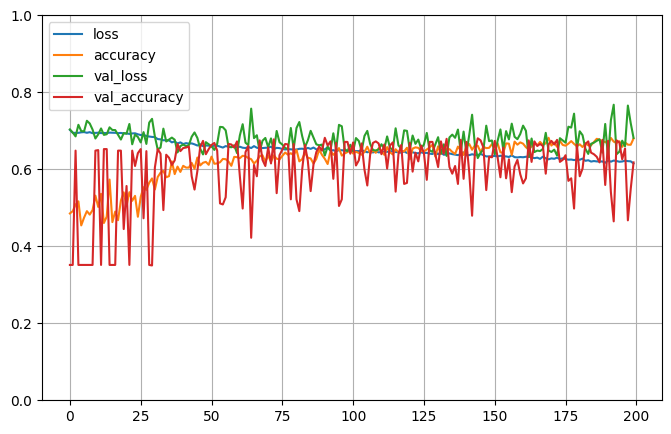


2023-03-29 22:28:35.668741

Testing # 2 1
2023-03-29 22:28:35.670633
2023-03-29 22:28:35.671011
PREDICT
2023-03-29 22:28:35.676146
Test 1:0 487:264 64.85%
Predict 1:0 406:345 54.06%
Test sizes (751, 1025) (751,)
Range of scores: 0.01568159 to 0.9758239
Score threshold 0.5
Confusion matrix
 [[161 103]
 [184 303]]
Normalized matrix
 [[0.21438083 0.13715047]
 [0.24500666 0.40346205]]


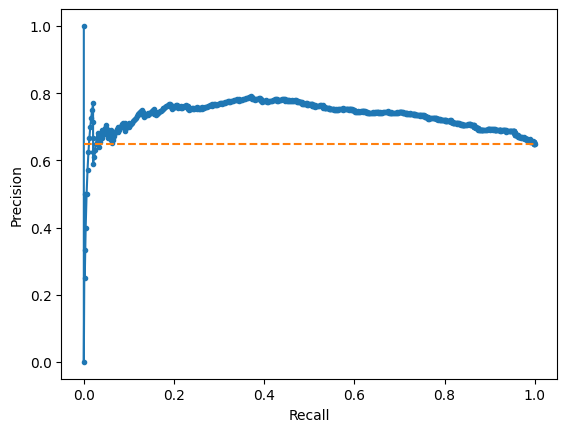

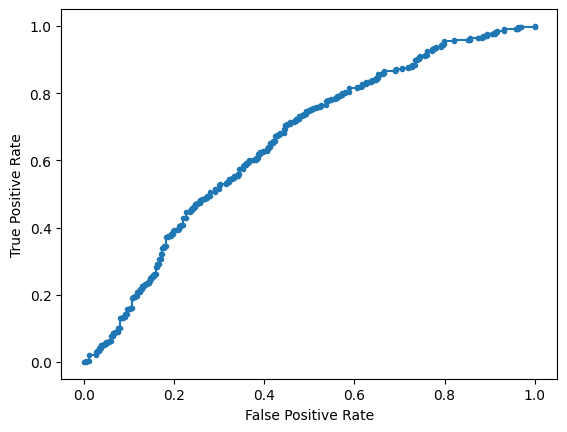

Accuracy: 61.78% Precision: 74.63% Recall: 62.22%
F1: 67.86% MCC: 0.2223
AUPRC: 73.26% AUROC: 65.49%
 accuracy [61.784287616511314]
 precision [74.63054187192118]
 recall [62.217659137576995]
 F1 [67.86114221724523]
 MCC [0.22229454411950142]
 AUPRC [73.2564321294218]
 AUROC [65.48674631323502]
2023-03-29 22:28:36.410145

Training # 2 2
2023-03-29 22:28:36.411559
2023-03-29 22:28:36.411605
Discriminator ZERO -1
Train 1:0 1922:1106 63.47%
Computed class weights: {0: 1.3688969258589512, 1: 0.7877211238293444}
Valid 1:0 477:269 63.94%
FIT
2023-03-29 22:28:36.479639


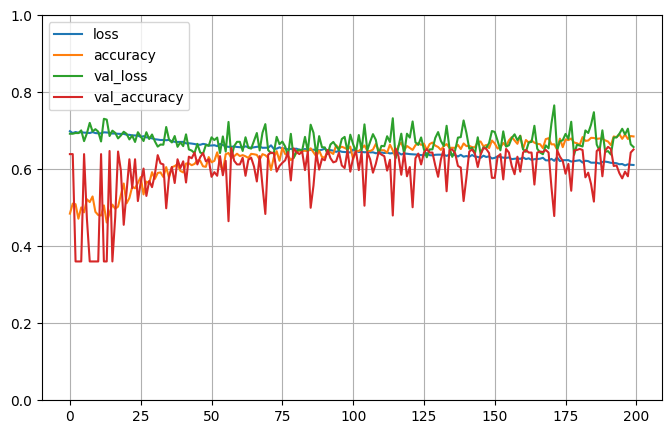


2023-03-29 22:29:59.392165

Testing # 2 2
2023-03-29 22:29:59.394304
2023-03-29 22:29:59.395771
PREDICT
2023-03-29 22:29:59.403178
Test 1:0 477:269 63.94%
Predict 1:0 535:211 71.72%
Test sizes (746, 1025) (746,)
Range of scores: 0.025717488 to 0.9710303
Score threshold 0.5
Confusion matrix
 [[110 159]
 [101 376]]
Normalized matrix
 [[0.14745308 0.21313673]
 [0.13538874 0.50402145]]


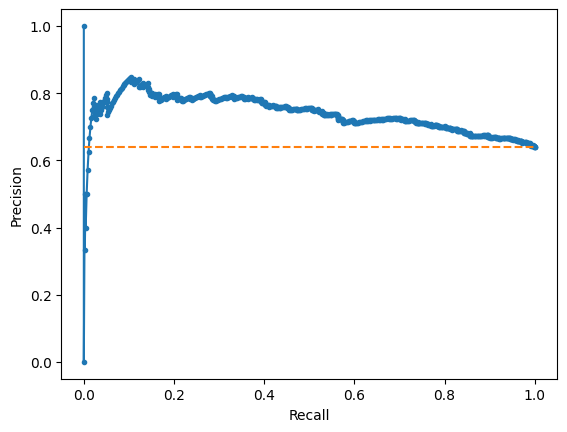

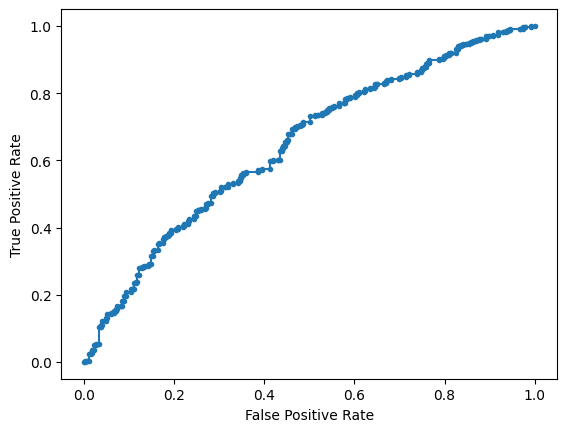

Accuracy: 65.15% Precision: 70.28% Recall: 78.83%
F1: 74.31% MCC: 0.2102
AUPRC: 73.85% AUROC: 64.47%
 accuracy [65.14745308310992]
 precision [70.2803738317757]
 recall [78.82599580712788]
 F1 [74.30830039525692]
 MCC [0.21022494060266697]
 AUPRC [73.84803504238332]
 AUROC [64.46657782142105]
2023-03-29 22:30:00.128428

Training # 2 3
2023-03-29 22:30:00.129776
2023-03-29 22:30:00.130028
Discriminator ZERO -1
Train 1:0 1915:1096 63.60%
Computed class weights: {0: 1.373631386861314, 1: 0.7861618798955614}
Valid 1:0 484:279 63.43%
FIT
2023-03-29 22:30:00.193321


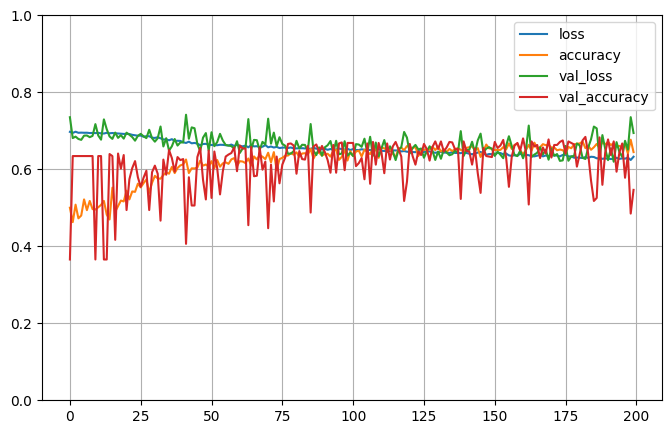


2023-03-29 22:30:58.071257

Testing # 2 3
2023-03-29 22:30:58.072694
2023-03-29 22:30:58.073075
PREDICT
2023-03-29 22:30:58.077778
Test 1:0 484:279 63.43%
Predict 1:0 252:511 33.03%
Test sizes (763, 1025) (763,)
Range of scores: 0.026401263 to 0.86769104
Score threshold 0.5
Confusion matrix
 [[222  57]
 [289 195]]
Normalized matrix
 [[0.29095675 0.07470511]
 [0.37876802 0.25557012]]


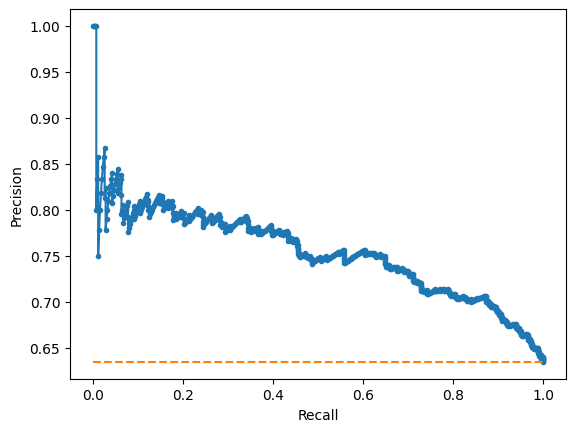

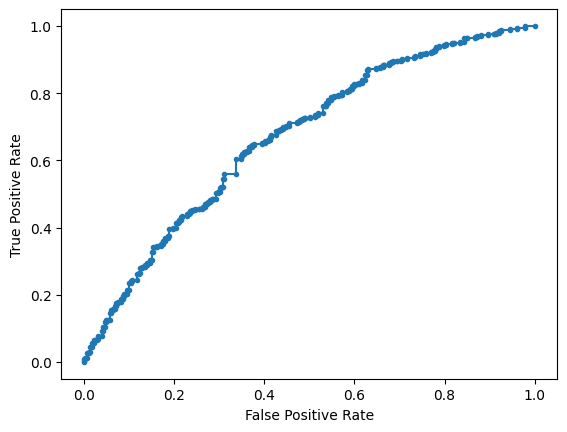

Accuracy: 54.65% Precision: 77.38% Recall: 40.29%
F1: 52.99% MCC: 0.2034
AUPRC: 75.36% AUROC: 66.92%
 accuracy [54.6526867627785]
 precision [77.38095238095238]
 recall [40.289256198347104]
 F1 [52.9891304347826]
 MCC [0.2033642873153639]
 AUPRC [75.35991822033779]
 AUROC [66.92363517876714]
2023-03-29 22:30:59.181388

Training # 2 4
2023-03-29 22:30:59.181691
2023-03-29 22:30:59.183479
Discriminator ZERO -1
Train 1:0 1935:1093 63.90%
Computed class weights: {0: 1.385178408051235, 1: 0.7824289405684755}
Valid 1:0 464:282 62.20%
FIT
2023-03-29 22:30:59.240291


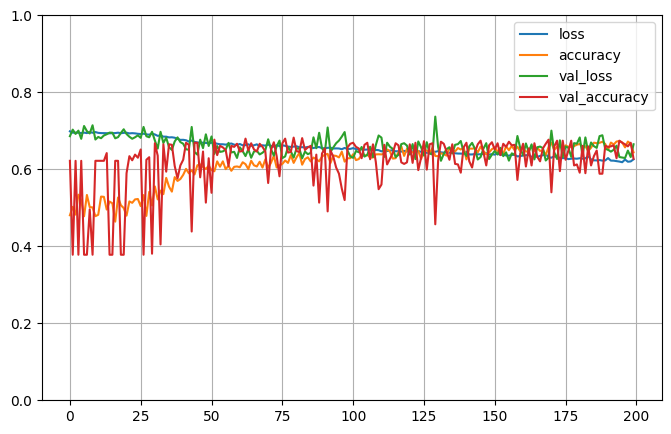


2023-03-29 22:31:56.838355

Testing # 2 4
2023-03-29 22:31:56.838502
2023-03-29 22:31:56.838547
PREDICT
2023-03-29 22:31:56.845415
Test 1:0 464:282 62.20%
Predict 1:0 368:378 49.33%
Test sizes (746, 1025) (746,)
Range of scores: 0.013123433 to 0.94009817
Score threshold 0.5
Confusion matrix
 [[191  91]
 [187 277]]
Normalized matrix
 [[0.25603217 0.12198391]
 [0.25067024 0.37131367]]


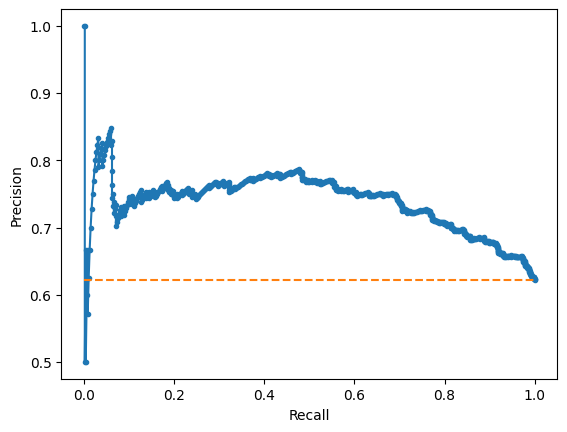

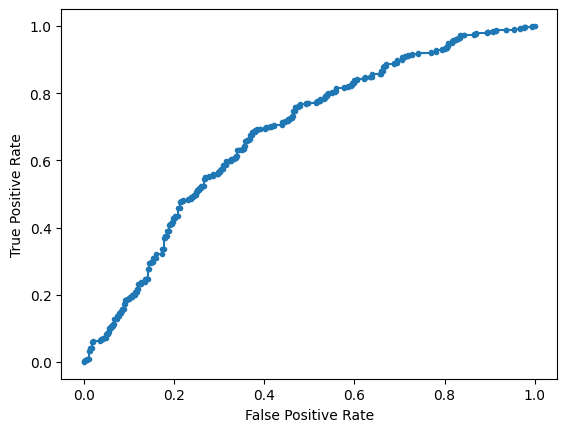

Accuracy: 62.73% Precision: 75.27% Recall: 59.70%
F1: 66.59% MCC: 0.2660
AUPRC: 73.82% AUROC: 67.98%
 accuracy [62.73458445040214]
 precision [75.27173913043478]
 recall [59.69827586206896]
 F1 [66.58653846153845]
 MCC [0.26602356222376894]
 AUPRC [73.82256712217196]
 AUROC [67.98499021765714]
2023-03-29 22:31:57.613228

Training # 2 5
2023-03-29 22:31:57.614338
2023-03-29 22:31:57.614408
Discriminator ZERO -1
Train 1:0 1912:1094 63.61%
Computed class weights: {0: 1.3738574040219378, 1: 0.7860878661087866}
Valid 1:0 487:281 63.41%
FIT
2023-03-29 22:31:57.676731


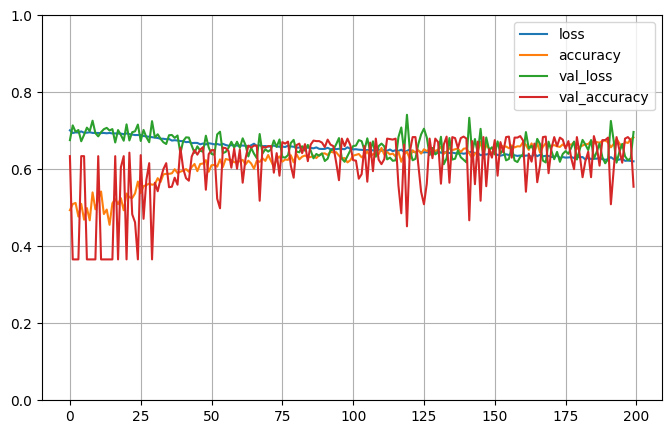


2023-03-29 22:33:20.731946

Testing # 2 5
2023-03-29 22:33:20.732263
2023-03-29 22:33:20.732315
PREDICT
2023-03-29 22:33:20.740985
Test 1:0 487:281 63.41%
Predict 1:0 261:507 33.98%
Test sizes (768, 1025) (768,)
Range of scores: 0.039307773 to 0.9492411
Score threshold 0.5
Confusion matrix
 [[223  58]
 [284 203]]
Normalized matrix
 [[0.29036458 0.07552083]
 [0.36979167 0.26432292]]


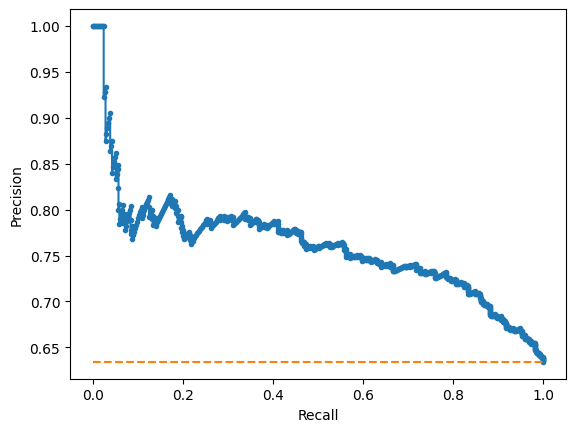

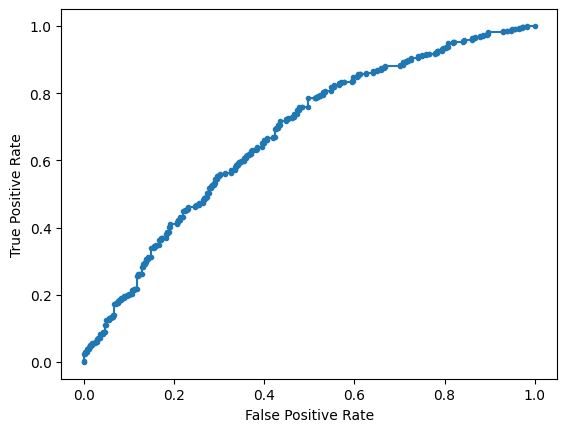

Accuracy: 55.47% Precision: 77.78% Recall: 41.68%
F1: 54.28% MCC: 0.2140
AUPRC: 76.02% AUROC: 67.60%
 accuracy [55.46875]
 precision [77.77777777777779]
 recall [41.68377823408625]
 F1 [54.27807486631016]
 MCC [0.21399586049397754]
 AUPRC [76.02205174031104]
 AUROC [67.59738978567304]
2023-03-29 22:33:21.232047


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 63.01% std 4.50
 precision mean 73.70% std 3.30
 recall mean 66.48% std 15.91
 F1 mean 68.60% std 8.49
 MCC mean 0.24% std 0.03
 AUPRC mean 74.41% std 1.24
 AUROC mean 66.56% std 1.38
 accuracy [[66.62180349932704], [66.01049868766404], [66.7563930013459], [66.17647058823529], [64.78149100257069], [61.784287616511314], [65.14745308310992], [54.6526867627785], [62.73458445040214], [55.46875]]
 precision [[73.62204724409449], [71.81467181467181], [74.94505494505495], [66.82926829268293], [74.43946188340807], [74.63054187192118], [70.2803738317757], [77.38095238095238], [75.27173913043478], [77.77777777777779]]
 recall [[76.63934426229508], [76.70103092783506], [71.94092827004219], [89.34782608695652], [67.47967479674797], [62.217659137576995], [78.82599580712788], [40.289256198347104], [59.69827586206896], [41.68377823408625]]
 F1 [[75.10040160642572], [74.17746759720838], [73.41227125941873], [76.46511627906978], [70.78891257995737], [67.86114221724523], [74.3083003952569